<a href="https://colab.research.google.com/github/BerkayYuce/football-player-market-value-prediction-model/blob/main/TST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1️⃣ Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

2️⃣ Dataset ve Model Sınıfları

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

class TSTEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()
    def forward(self, src):
        src2, attn_weights = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn_weights

class EnhancedTST(nn.Module):
    def __init__(self, n_features, d_model=128, n_heads=8, num_layers=3, d_ff=256, output_size=1, dropout=0.2, max_len=100):
        super().__init__()
        self.d_model = d_model
        self.n_features = n_features
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([
            TSTEncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.flatten = nn.Flatten()
        self.output_layer = nn.Sequential(
            nn.Linear(d_model * max_len, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_size)
        )
    def forward(self, x):
        x = self.input_proj(x)  # [batch, seq_len, d_model]
        x = self.pos_encoder(x)
        attn_weights = []
        for layer in self.encoder_layers:
            x, attn = layer(x)
            attn_weights.append(attn)
        x = self.flatten(x)
        out = self.output_layer(x)
        return out.squeeze(-1), attn_weights

class FootballDataset(Dataset):
    def __init__(self, X, y, seq_len=5, n_features=None):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.n_features = n_features if n_features else X.shape[1] // seq_len
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x_seq = self.X[idx].reshape(self.seq_len, self.n_features)
        y_val = self.y[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered at counter {self.counter}")

def safe_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100


3️⃣ Dosya Yükle & Feature/Scaler Hazırlık

In [ ]:
# Dosyaları: /content/train.csv, /content/val.csv, /content/test.csv
train = pd.read_csv('/content/train.csv')
val   = pd.read_csv('/content/val.csv')
test  = pd.read_csv('/content/test.csv')

target_col = "target"
id_cols = ["Oyuncu_ID", "Date"]
seq_len = 5

# Ortak feature tespiti
feature_cols = [col for col in train.columns if col not in [target_col] + id_cols]
feature_sets = [
    set([col.replace(f"_t{i}", "") for col in feature_cols if col.endswith(f"_t{i}")])
    for i in range(1, seq_len + 1)
]
common_features = sorted(set.intersection(*feature_sets))

ordered_cols = [f"{feat}_t{i}" for i in range(1, seq_len+1) for feat in common_features]

def prepare_X_y(df):
    X = df[ordered_cols].values
    y = df[target_col].values
    return X, y

X_train, y_train = prepare_X_y(train)
X_val, y_val = prepare_X_y(val)
X_test, y_test = prepare_X_y(test)

# NaN/Inf düzeltme
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val   = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test  = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
y_val   = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)
y_test  = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

# Ölçeklendirme
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).flatten()
y_val_scaled   = scaler_y.transform(y_val.reshape(-1,1)).flatten()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1)).flatten()

dataset_train = FootballDataset(X_train_scaled, y_train_scaled, seq_len=seq_len, n_features=len(common_features))
dataset_val   = FootballDataset(X_val_scaled,   y_val_scaled,   seq_len=seq_len, n_features=len(common_features))
dataset_test  = FootballDataset(X_test_scaled,  y_test_scaled,  seq_len=seq_len, n_features=len(common_features))

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=64, shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=64, shuffle=False)


4️⃣ Model Kurulumu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

model = EnhancedTST(
    n_features=len(common_features),
    d_model=128,
    n_heads=8,
    num_layers=3,
    d_ff=256,
    output_size=1,
    dropout=0.2,
    max_len=seq_len
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=100, pct_start=0.3
)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=15, min_delta=0.001)


Kullanılan cihaz: cpu


5️⃣ Eğitim ve Değerlendirme

In [ ]:
train_losses, val_losses = [], []
best_model_path = 'best_enhanced_tst_model.pth'
start_time = time.time()

for epoch in range(100):
    model.train()
    epoch_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred, _ = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred, _ = model(xb)
            val_loss += criterion(pred, yb).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if avg_val_loss < early_stopping.best_loss:
        torch.save(model.state_dict(), best_model_path)
    if epoch % 5 == 0 or epoch < 10:
        print(f"Epoch {epoch+1:3d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

training_time = time.time() - start_time
print(f"\nEğitim süresi: {training_time:.2f} saniye")

# Değerlendirme
model.load_state_dict(torch.load(best_model_path))
model.eval()
y_true, y_pred = [], []
attn_weights_all = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds, attn_weights = model(xb)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(yb.numpy())
        attn_weights_all.append(attn_weights)

y_true_inv = scaler_y.inverse_transform(np.array(y_true).reshape(-1,1)).flatten()
y_pred_inv = scaler_y.inverse_transform(np.array(y_pred).reshape(-1,1)).flatten()

mse = mean_squared_error(y_true_inv, y_pred_inv)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)
mape = safe_mape(y_true_inv, y_pred_inv)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Skoru: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Eğitim Süresi: {training_time:.2f} saniye")


Epoch   1 | Train Loss: 0.8984 | Val Loss: 0.6238 | LR: 4.26e-05
Epoch   2 | Train Loss: 0.7278 | Val Loss: 0.6182 | LR: 5.05e-05
Epoch   3 | Train Loss: 0.6153 | Val Loss: 0.5535 | LR: 6.36e-05
Epoch   4 | Train Loss: 0.4995 | Val Loss: 0.4534 | LR: 8.17e-05
Epoch   5 | Train Loss: 0.4007 | Val Loss: 0.4258 | LR: 1.05e-04
Epoch   6 | Train Loss: 0.3328 | Val Loss: 0.3387 | LR: 1.32e-04
Epoch   7 | Train Loss: 0.2684 | Val Loss: 0.3457 | LR: 1.64e-04
Epoch   8 | Train Loss: 0.2402 | Val Loss: 0.2477 | LR: 1.99e-04
Epoch   9 | Train Loss: 0.2201 | Val Loss: 0.2382 | LR: 2.39e-04
Epoch  10 | Train Loss: 0.1765 | Val Loss: 0.2631 | LR: 2.81e-04
Epoch  11 | Train Loss: 0.1625 | Val Loss: 0.2348 | LR: 3.26e-04
Epoch  16 | Train Loss: 0.1113 | Val Loss: 0.3286 | LR: 5.72e-04
Epoch  21 | Train Loss: 0.0917 | Val Loss: 0.2653 | LR: 8.04e-04
Epoch  26 | Train Loss: 0.0758 | Val Loss: 0.2968 | LR: 9.60e-04
Epoch  31 | Train Loss: 0.0815 | Val Loss: 0.2543 | LR: 9.99e-04
Epoch  36 | Train Loss: 0

6️⃣ Görselleştirme ve Attention

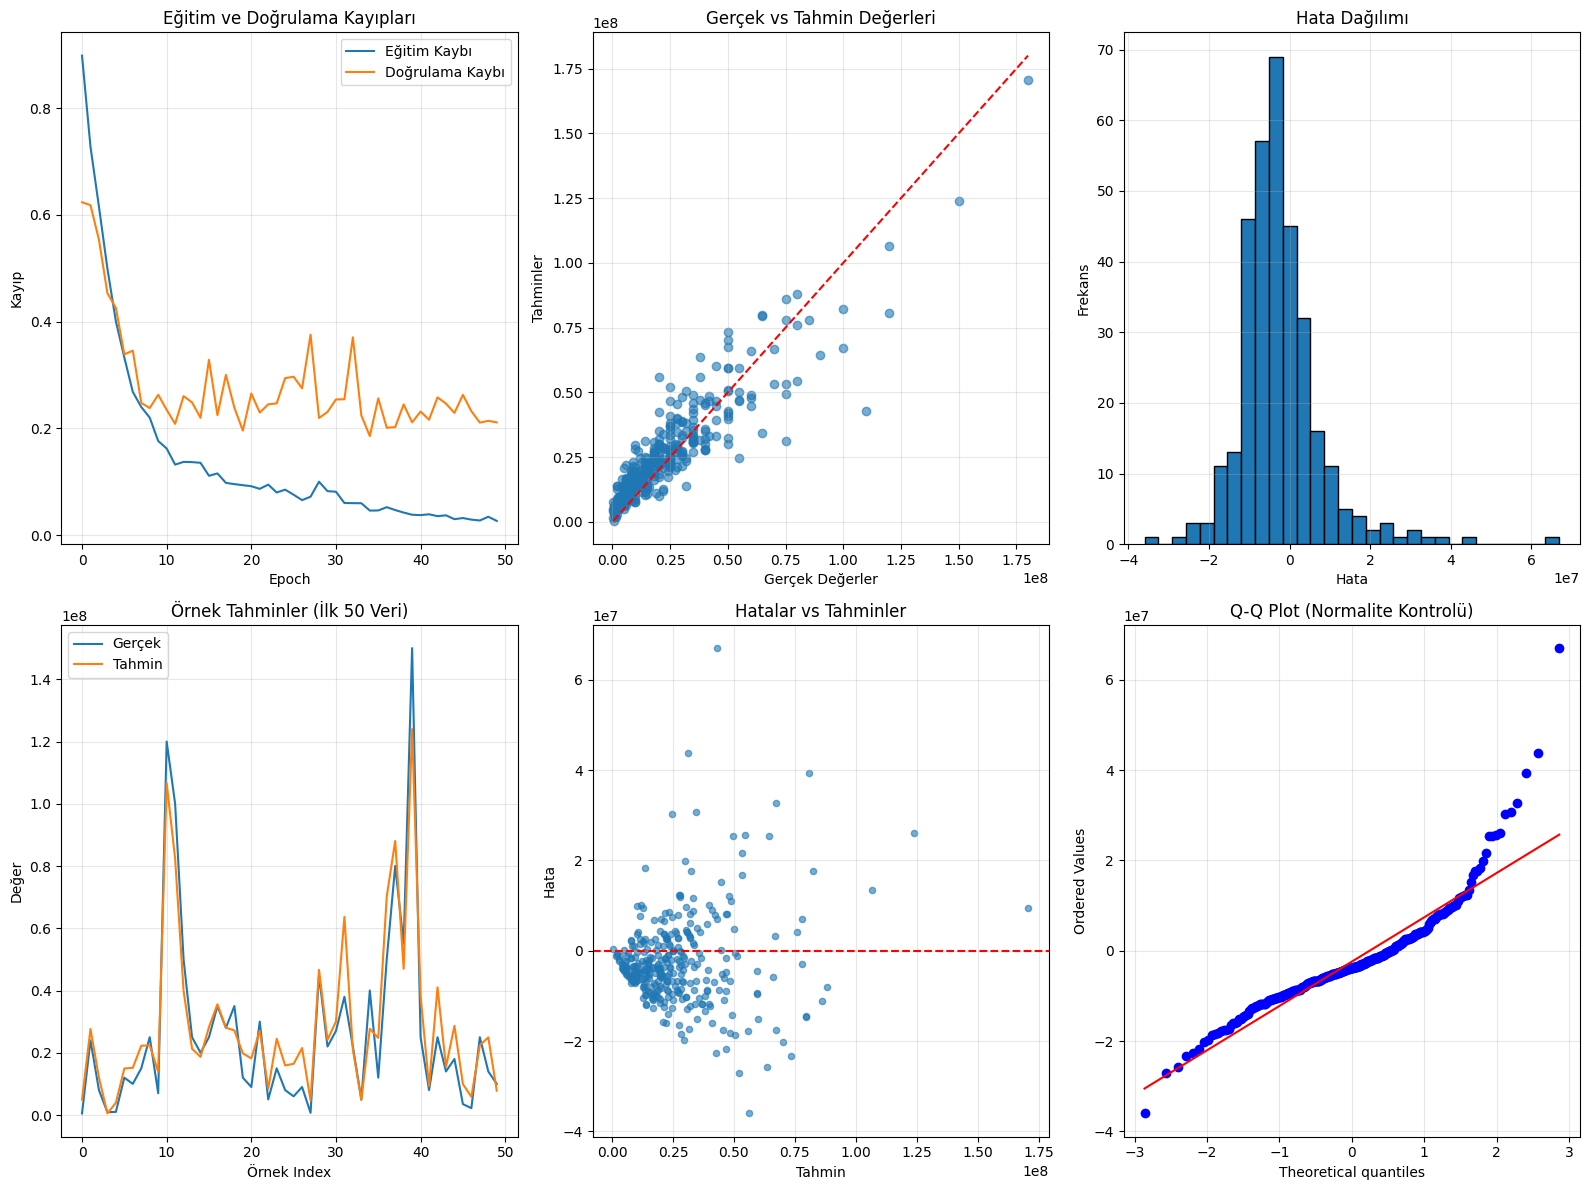

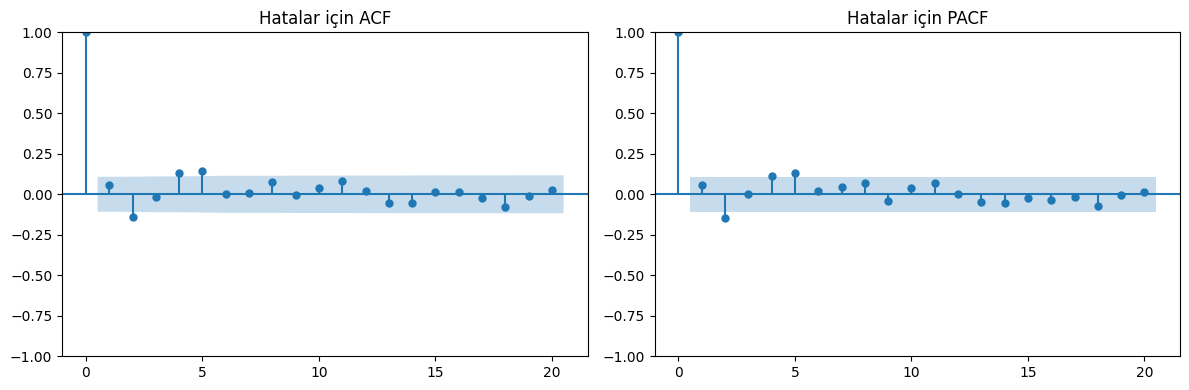

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# -- Klasik 4 plot: Loss, Scatter, Residual, Sequence --
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Eğitim Kaybı')
plt.plot(val_losses, label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 3, 2)
plt.scatter(y_true_inv, y_pred_inv, alpha=0.6)
plt.plot([min(y_true_inv), max(y_true_inv)], [min(y_true_inv), max(y_true_inv)], 'r--')
plt.title('Gerçek vs Tahmin Değerleri')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.grid(alpha=0.3)

residuals = y_true_inv - y_pred_inv
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Hata Dağılımı')
plt.xlabel('Hata')
plt.ylabel('Frekans')
plt.grid(alpha=0.3)

plt.subplot(2, 3, 4)
sample_size = min(50, len(y_true_inv))
plt.plot(y_true_inv[:sample_size], label='Gerçek')
plt.plot(y_pred_inv[:sample_size], label='Tahmin')
plt.title('Örnek Tahminler (İlk 50 Veri)')
plt.xlabel('Örnek Index')
plt.ylabel('Değer')
plt.legend()
plt.grid(alpha=0.3)

# -- Ek: Hatalar vs Tahminler --
plt.subplot(2, 3, 5)
plt.scatter(y_pred_inv, residuals, alpha=0.6, s=20)
plt.axhline(0, color='red', linestyle='--')
plt.title('Hatalar vs Tahminler')
plt.xlabel('Tahmin')
plt.ylabel('Hata')
plt.grid(alpha=0.3)

# --- Ekstra: ACF/PACF (ayrı pencerede) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, lags=20, ax=ax1, title="Hatalar için ACF")
plot_pacf(residuals, lags=20, ax=ax2, title="Hatalar için PACF")
plt.tight_layout()
plt.show()